# How do acoustic features of songs influence their rank? 

Authors: Yashas Lokesh, Renee Yang, Kavya Dagli

Musicologist Dr. Alison Pawley and psychologist Dr. Daniel Mullensiefen out at the University of London claim that it is possible to identify if a song will be popular. Two of the attributes that they predict make songs popular are "longer and detailed musical phrases" and "a higher number of pitches." We will put this claim to the test by analyzing the relationship between song audio features and song rank. We will also explore if there are additional features that influence popularity. 

![](billboard_img.jpg)

# 1. Getting Started

## 1.1 Required Libraries 

In [1]:
import pandas as pd
import sqlite3
import sqlalchemy as db
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from statsmodels import api as sm

## 1.2 Dataset Source

The dataset we use is scraped comes from two different sources. The first source is the Billboard Top 100 data over 100 years. This dataset includes the rank of albums overtime. 

This data can be accessed here: LINK

The second source comes from AllMusic. This dataset includes songs in albums and various audio features of each song such as instrumentalness, energy, and valence. 

This data can be accessed here: LINK


## 1.3 Load and View Data 

In [2]:
#connect to database
engine = db.create_engine('sqlite:///billboard-200 2.db')
conn = engine.connect()

In [3]:
#convert acoustic_features table to dataframe
acoustic_features = pd.read_sql_table('acoustic_features', conn)
acoustic_features.head()

,id,song,album,artist,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,album_id,date
0,0Veyvc3n9AcLSoK3r1dA12,Voices In My Head,Hoodie SZN,A Boogie Wit da Hoodie,0.0555,0.754,142301.0,0.663,0.000000,6.0,0.101,-6.311,0.0,0.427,90.195,4.0,0.207,3r5hf3Cj3EMh1C2saQ8jyt,2018-12-21
1,77JzXZonNumWsuXKy9vr3U,Beasty,Hoodie SZN,A Boogie Wit da Hoodie,0.2920,0.860,152829.0,0.418,0.000000,7.0,0.106,-9.061,0.0,0.158,126.023,4.0,0.374,3r5hf3Cj3EMh1C2saQ8jyt,2018-12-21
2,18yllZD0TdF7ykcREib8Z1,I Did It,Hoodie SZN,A Boogie Wit da Hoodie,0.1530,0.718,215305.0,0.454,0.000046,8.0,0.116,-9.012,1.0,0.127,89.483,4.0,0.196,3r5hf3Cj3EMh1C2saQ8jyt,2018-12-21
3,1wJRveJZLSb1rjhnUHQiv6,Swervin (feat. 6ix9ine),Hoodie SZN,A Boogie Wit da Hoodie,0.0153,0.581,189487.0,0.662,0.000000,9.0,0.111,-5.239,1.0,0.303,93.023,4.0,0.434,3r5hf3Cj3EMh1C2saQ8jyt,2018-12-21
4,0jAfdqv18goRTUxm3ilRjb,Startender (feat. Offset and Tyga),Hoodie SZN,A Boogie Wit da Hoodie,0.0235,0.736,192779.0,0.622,0.000000,6.0,0.151,-4.653,0.0,0.133,191.971,4.0,0.506,3r5hf3Cj3EMh1C2saQ8jyt,2018-12-21


In [4]:
acoustic_features.describe()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
count,339850.000000,339850.000000,3.398500e+05,339850.000000,339850.000000,339850.000000,339850.000000,339850.000000,339850.000000,339850.000000,339850.000000,339850.000000,339850.000000
mean,0.298806,0.541176,2.367351e+05,0.616716,0.098277,5.239526,0.233439,-9.072759,0.705700,0.092625,119.933974,3.887547,0.506169
std,0.315533,0.170821,1.022557e+05,0.244043,0.241980,3.553370,0.215256,4.601032,0.455728,0.128894,30.380899,0.453673,0.253193
min,0.000000,0.000000,1.062000e+03,0.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.021500,0.425000,1.865218e+05,0.440000,0.000000,2.000000,0.098200,-11.575000,0.000000,0.033400,96.188250,4.000000,0.302000
50%,0.164000,0.547000,2.263730e+05,0.647000,0.000053,5.000000,0.141000,-8.121000,1.000000,0.044700,118.223000,4.000000,0.506000
75%,0.546000,0.664000,2.710000e+05,0.822000,0.011100,8.000000,0.299000,-5.679000,1.000000,0.084000,139.288000,4.000000,0.712000
max,0.996000,0.988000,4.734079e+06,1.000000,1.000000,11.000000,1.000000,3.744000,1.000000,0.968000,247.824000,5.000000,1.000000


In [5]:
#convert albums table to dataframe
albums = pd.read_sql_table('albums', conn)
albums.head()

,id,date,artist,album,rank,length,track_length
0,1,None,None,None,None,NaN,NaN
1,2,2019-01-19,A Boogie Wit da Hoodie,Hoodie SZN,1,20.0,185233.800000
2,3,2019-01-19,21 Savage,I Am > I Was,2,15.0,211050.733333
3,4,2019-01-19,Soundtrack,Spider-Man: Into The Spider-Verse,3,13.0,190866.384615
4,5,2019-01-19,Meek Mill,Championships,4,19.0,219173.894737


In [6]:
albums.describe()

,id,length,track_length
count,573947.000000,492547.000000,4.688670e+05
mean,286974.000000,13.728933,2.443541e+05
std,165684.371813,7.960640,7.195498e+04
min,1.000000,1.000000,2.542290e+04
25%,143487.500000,10.000000,2.100814e+05
50%,286974.000000,12.000000,2.372190e+05
75%,430460.500000,15.000000,2.680566e+05
max,573947.000000,666.000000,4.457023e+06


## 1.4 Cleaning and Modifying Data 

After viewing the data, it is apparent that many of the features contain null values. We decided to drop these values to prevent complications with performing operations on the two dataframes later on. 

In [7]:
#drop null values in both tables
acoutstic_features = acoustic_features.dropna()
albums = albums.dropna()

We combined the two dataframes here so that the rank of each album could be accessed from the ACOUSTIC_FEATURES dataframe. We decided to extract the best rank for an album from the ALBUMS dataframe and place it in the 'rank' column of ACOUSTIC_FEATURES. We will start by creating a dictionary that maps the album to its best rank.

In [8]:
#function to get highest rank for albums
def highest_rank(df, album):
    target = df[df.album == album]
    #"highest" rank means lowest value in rank column 
    return target['rank'].min()

#populate dictionary with highest rank of each album
ranks = {}
for a in albums["album"].unique():
    ranks[a] = highest_rank(albums, a)

Now that we have mapped albums to their best rank, we will create the 'rank' column in ACOUSTIC_FEATURES. We noticed that some albums in ACOUSTIC_FEATURES do not appear in ALBUMS so we could not get a best rank for them. In this case we set that album's rank as NaN and dropped the row. 

In [9]:
#create rank column in ACOUSTIC_FEATURES 
col = []
for index, row in acoustic_features.iterrows():
    '''
    if album exists in ACOUSTIC_FEATURES place, 
    otherwise set to null
    '''
    try:
        col.append(int(ranks[row['album']]))
    except:
        col.append(np.nan)
acoustic_features['rank'] = col

Finally, we have a table containing all song's acoustic features and their album's corresponding rank!

In [10]:
#drop any null values we set in the above step
acoustic_features = acoustic_features.dropna()
acoustic_features.head()

,id,song,album,artist,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,album_id,date,rank
0,0Veyvc3n9AcLSoK3r1dA12,Voices In My Head,Hoodie SZN,A Boogie Wit da Hoodie,0.0555,0.754,142301.0,0.663,0.000000,6.0,0.101,-6.311,0.0,0.427,90.195,4.0,0.207,3r5hf3Cj3EMh1C2saQ8jyt,2018-12-21,1.0
1,77JzXZonNumWsuXKy9vr3U,Beasty,Hoodie SZN,A Boogie Wit da Hoodie,0.2920,0.860,152829.0,0.418,0.000000,7.0,0.106,-9.061,0.0,0.158,126.023,4.0,0.374,3r5hf3Cj3EMh1C2saQ8jyt,2018-12-21,1.0
2,18yllZD0TdF7ykcREib8Z1,I Did It,Hoodie SZN,A Boogie Wit da Hoodie,0.1530,0.718,215305.0,0.454,0.000046,8.0,0.116,-9.012,1.0,0.127,89.483,4.0,0.196,3r5hf3Cj3EMh1C2saQ8jyt,2018-12-21,1.0
3,1wJRveJZLSb1rjhnUHQiv6,Swervin (feat. 6ix9ine),Hoodie SZN,A Boogie Wit da Hoodie,0.0153,0.581,189487.0,0.662,0.000000,9.0,0.111,-5.239,1.0,0.303,93.023,4.0,0.434,3r5hf3Cj3EMh1C2saQ8jyt,2018-12-21,1.0
4,0jAfdqv18goRTUxm3ilRjb,Startender (feat. Offset and Tyga),Hoodie SZN,A Boogie Wit da Hoodie,0.0235,0.736,192779.0,0.622,0.000000,6.0,0.151,-4.653,0.0,0.133,191.971,4.0,0.506,3r5hf3Cj3EMh1C2saQ8jyt,2018-12-21,1.0


# 2. Exploring Popular Songs 

## 2.1 Audio Features of Top Songs 

Now that we have modified our ACOUSTIC_FEATURES dataset to our linking, let's start by exploring the top songs in the dataset. Top songs are those that belong to albums with a number one ranking, as indicated by the 'rank' column. We will first isolate the top songs into their own dataframe. 

In [11]:
#isolate songs that were ranked at #1
top_songs = acoustic_features[acoustic_features['rank'] == 1]
len(top_songs)

13626

We are able to find 13626 top songs in our table! Here are a few #1 hits:

In [12]:
top_songs.sample(n=5)

,id,song,album,artist,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,album_id,date,rank
6445,0etbeacNEukXXNPOlXzZmu,Disappear,I Am...Sasha Fierce,Beyonce,0.12800,0.492,267453.0,0.348,0.000000,5.0,0.3260,-10.676,1.0,0.0301,78.412,4.0,0.206,39P7VD7qlg3Z0ltq60eHp7,2008-11-14,1.0
260296,7l7bx4f3WkkQ5IfgPC0cw9,Romeo,Flashdance,Soundtrack,0.08410,0.800,193467.0,0.771,0.000369,4.0,0.0870,-11.140,1.0,0.0413,143.401,4.0,0.963,3R6Z3Hp8EMdhgkA5t89NiL,1983-04-11,1.0
7207,5NQXHsUUF006GrtFD5NgDZ,Hungover In A Hotel Room,What Makes You Country,Luke Bryan,0.19400,0.535,234894.0,0.841,0.000000,2.0,0.0973,-2.303,0.0,0.0320,136.068,4.0,0.454,6NUEU1vyIctdAg8IHot8Wy,2017-12-08,1.0
110309,3pRURfm0THUY3G4YBOLtrC,See You Again - Rock Mafia Remix,Breakout,Miley Cyrus,0.00979,0.671,196093.0,0.953,0.000002,9.0,0.1360,-5.350,0.0,0.0616,138.949,4.0,0.806,0Yu3czJNOQ68fZgkvpjuHL,2008-01-01,1.0
99745,4WBmkMJyWubRXRLYk8t9SI,Crossroads,Battle Studies,John Mayer,0.22100,0.894,149387.0,0.507,0.066100,7.0,0.0642,-6.945,1.0,0.0564,114.216,4.0,0.916,1V5vQRMWTNGmqwxY8jMVou,2009-11-13,1.0


Now we will average each audio feature to get an idea of the audio features for popular songs.

In [13]:
#grab audio feature columns
top_song_avg = top_songs.loc[:,'acousticness':'valence'].mean()
top_song_avg = top_song_avg.sort_values()
top_song_avg

loudness                -8.200638
instrumentalness         0.063410
speechiness              0.104092
liveness                 0.211498
acousticness             0.264981
valence                  0.498196
danceability             0.568460
energy                   0.630837
mode                     0.677969
time_signature           3.907750
key                      5.258697
tempo                  119.231669
duration_ms         237258.667914
dtype: float64

We are dropping some of the very large and very small values for the purpose of graphing, but don't worry we'll include them in our analysis.

In [14]:
top_song_avg = top_song_avg.drop(labels=['duration_ms', 'tempo', 'loudness'])

Here is a plot of the average features of #1 ranked songs:

In [15]:
plt.style.use('seaborn-pastel')

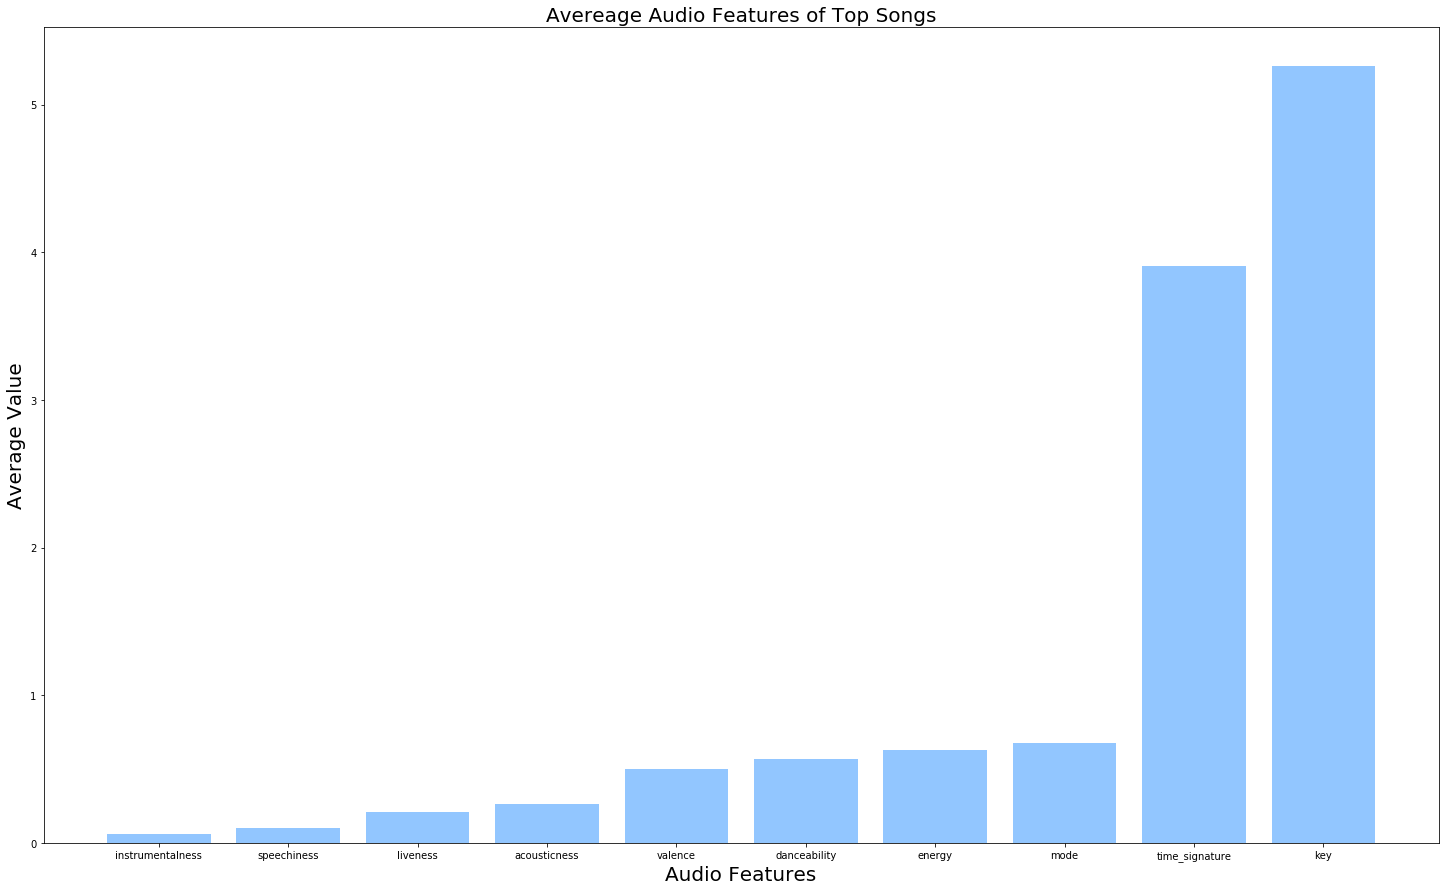

In [16]:
#plot audio features for high-ranked songs
plt.figure(figsize=(25,15))
plt.title("Avereage Audio Features of Top Songs", fontsize=20)
plt.xlabel("Audio Features", fontsize=20)
plt.ylabel("Average Value", fontsize=20)
plt.bar(top_song_avg.keys(),top_song_avg)
plt.show()

## 2.2 Popular Songs vs. Low Ranked Songs 

In order to compare the audio features of low-ranked songs to high-ranked songs, let's first look at the lowest rank in our table. We can do this by getting the value counts of the data in the 'rank' column. 

In [17]:
#get counts of ranks
acoustic_features['rank'].value_counts().sort_index()

1.0      13626
3.0         16
4.0         11
5.0         22
6.0         15
         ...  
196.0      897
197.0      906
198.0      934
199.0      710
200.0      830
Name: rank, Length: 199, dtype: int64

Now we know that the lowest rank a song can achieve is 200. Getting the count of each rank has also indicated that we have a sizeable sample to calculate an average from! (818 songs to be exact)

In [18]:
#isolate low ranked songs
low_ranked = acoustic_features[acoustic_features['rank'] == 200]
low_ranked.head()

,id,song,album,artist,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,album_id,date,rank
9514,6PY0zFbmh6TWMQDDnJqKmi,Just A Fool,Uniform Distortion,Jim James,0.4190,0.485,240040.0,0.723,0.045900,4.0,0.1510,-6.729,1.0,0.0438,118.143,4.0,0.515,7bDsFXWrq3zXuyQlIzJU6j,2018-06-29,200.0
9515,0Evixriu8Jdn5vkXXTTCqV,You Get To Rome,Uniform Distortion,Jim James,0.1080,0.400,148200.0,0.892,0.000000,11.0,0.3060,-4.427,0.0,0.0899,129.838,4.0,0.382,7bDsFXWrq3zXuyQlIzJU6j,2018-06-29,200.0
9516,1kEhCIq9sfLADamf4Tm5jT,Out Of Time,Uniform Distortion,Jim James,0.0442,0.221,171760.0,0.818,0.001750,2.0,0.2280,-5.788,1.0,0.0864,102.079,4.0,0.261,7bDsFXWrq3zXuyQlIzJU6j,2018-06-29,200.0
9517,7FWL3U5cjcbLZxLzBKJbXC,Throwback,Uniform Distortion,Jim James,0.0224,0.402,318800.0,0.864,0.000007,6.0,0.0777,-5.316,1.0,0.0481,117.281,4.0,0.487,7bDsFXWrq3zXuyQlIzJU6j,2018-06-29,200.0
9518,2v96SpFC6LS53llretL3kN,No Secrets,Uniform Distortion,Jim James,0.3260,0.452,292533.0,0.673,0.000126,11.0,0.0986,-6.037,1.0,0.0329,112.050,4.0,0.290,7bDsFXWrq3zXuyQlIzJU6j,2018-06-29,200.0


In [19]:
#get audio features for low ranked songs 
low_ranked_avg = low_ranked.loc[:,'acousticness':'valence'].mean()
low_ranked_avg = low_ranked_avg.sort_values()
low_ranked_avg

loudness                -8.003887
speechiness              0.079857
instrumentalness         0.122415
liveness                 0.235199
acousticness             0.262511
valence                  0.501521
danceability             0.522401
energy                   0.662895
mode                     0.707229
time_signature           3.883133
key                      5.490361
tempo                  121.249167
duration_ms         242261.644578
dtype: float64

Again dropping very low and very high values...

In [20]:
low_ranked_avg = low_ranked_avg.drop(labels=['duration_ms', 'tempo', 'loudness'])

Since we have the average data for the lowest and highest ranked songs we can graph them side-by-side and see if the value differ

In [21]:
#create side-by-side bar graph for low vs high ranked songs
ind = np.arange(len(low_ranked_avg))  
#
set distance between bars
width = 0.35       

fig = plt.figure(figsize=(25,15))
ax = fig.add_subplot(111)
avgs1 = ax.bar(ind, top_song_avg, width, color='#CC998D')
avgs2 = ax.bar(ind+width, low_ranked_avg, width, color='#429EA6')

ax.set_ylabel('Average Value', fontsize=20)
ax.set_xlabel('Audio Features', fontsize=20)
ax.set_title('Average Audio Features of High and Low Ranked Songs')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(top_song_avg.keys())
ax.legend( (avgs1[0], avgs2[0]), ('High Rated', 'Low Rated') )
plt.show()

SyntaxError: invalid syntax (<ipython-input-21-cdfd13a2bc97>, line 4)

**Observations**

- There are no drastic differences between features of low and high rated songs
- 'key' is higher for low-rated songs
- high-rated songs are slightly longer 
- all other features are higher in value for low-rated songs, exept for danceability 

A bar graph of the difference in each feature will better demonstrate the change in average feature value between low and high rated songs. 

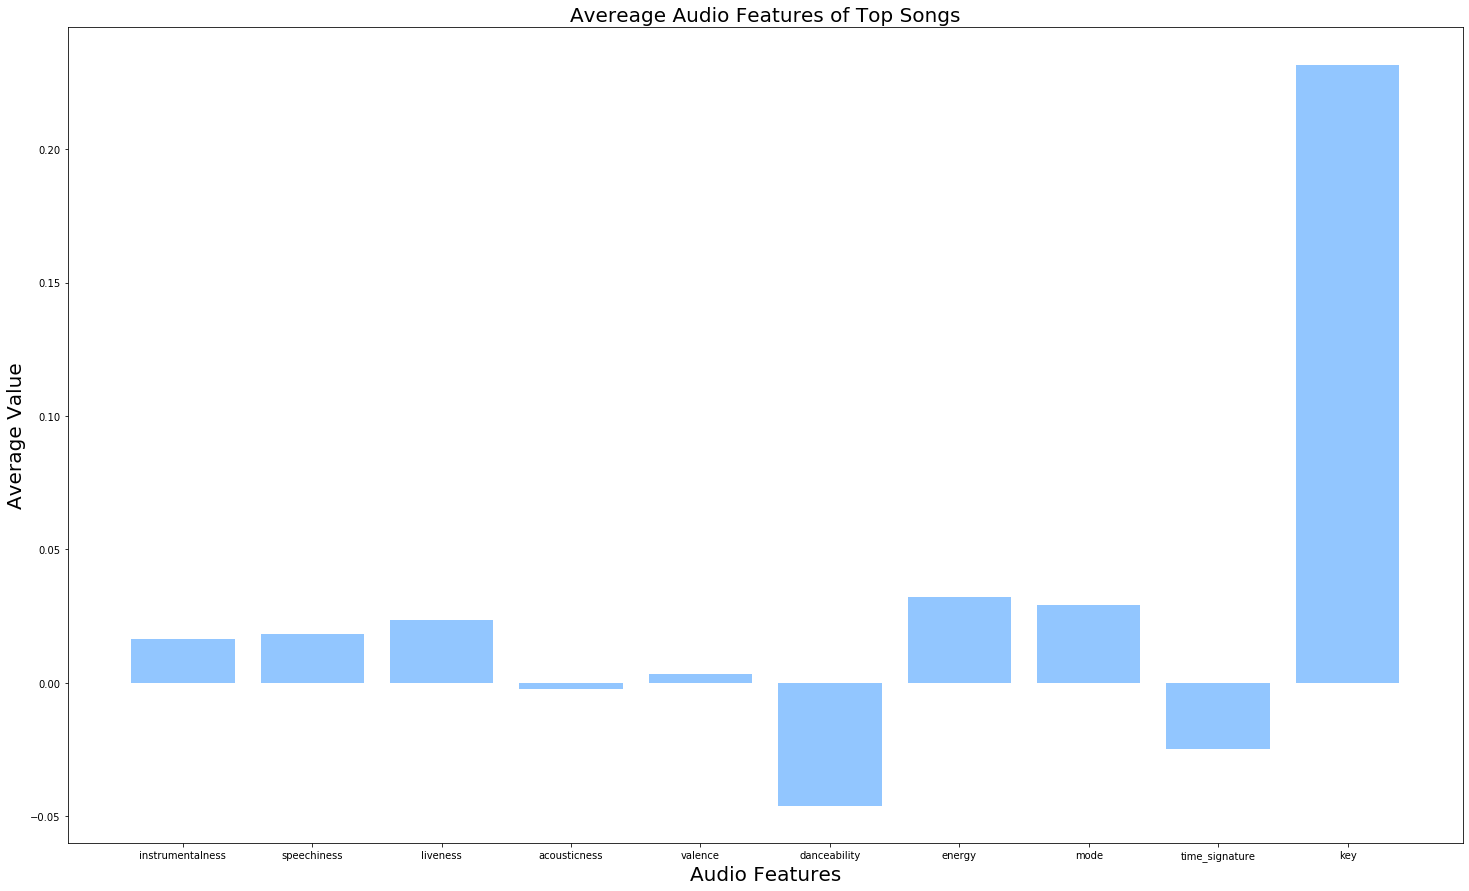

In [22]:
#get difference between values for high and low ranked songs
diffs = [a - b for a, b in zip(low_ranked_avg, top_song_avg)]

#plot
plt.figure(figsize=(25,15))
plt.title("Avereage Audio Features of Top Songs", fontsize=20)
plt.xlabel("Audio Features", fontsize=20)
plt.ylabel("Average Value", fontsize=20)
plt.bar(top_song_avg.keys(),diffs)
plt.show()

**Observations**

- The highest difference between averages is for 'key'
- The second highest difference is for 'dancibility'
- All other differences seem to be less than or around 0.25

This may indicate that key and dancibility are highly influenctial in determining a song's rank. To evaluate this, we will determine the correlation of these factors in our analysis section.

# 3. Exploring Middle Ground

## 3.1 Slicing Ranks

Since there was the greatest difference in the average value for the 'key' of top-ranked songs and low-ranked songs, we decided to look at what the value of 'key' was for other levels of rank. We did this by creating a violin-plot where we demonstrate the distribution of 'key' value for each level of rank. Since ranks can be 1-200, we will begin by slicing the ranks into groups of 10 (<= 10, <=20, etc.) 

In [23]:
#convert rank column to int for binning
acoustic_features['rank'] = acoustic_features['rank'].astype(int)
#bin rank values
acoustic_features['rank_bins'] = pd.cut(acoustic_features['rank'], np.arange(0,201,10))
acoustic_features.loc[0:5,'rank':'rank_bins']

,rank,rank_bins
0,1,"(0, 10]"
1,1,"(0, 10]"
2,1,"(0, 10]"
3,1,"(0, 10]"
4,1,"(0, 10]"
5,1,"(0, 10]"


## 3.2 Measuring Distrubution of 'Key' per Rank

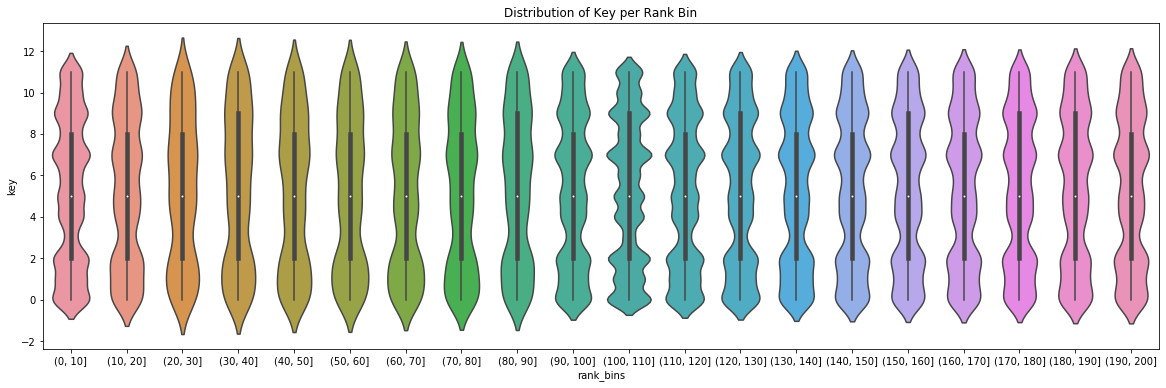

In [24]:
#plot distributions for key value
plt.figure(figsize=(20, 6))
plt.title("Distribution of Key per Rank Bin")
ax = sns.violinplot(x=acoustic_features["rank_bins"], y=acoustic_features['key'])

**Observations**

- There is no clear change in key from high to low ranks
- Highly-ranked songs do seem to have a slightly lower key than lower ranks
- Many songs seem to have low key values or high key values relative to the range of values



## 3.3 Measuring Distribution of 'Danceability' per Rank

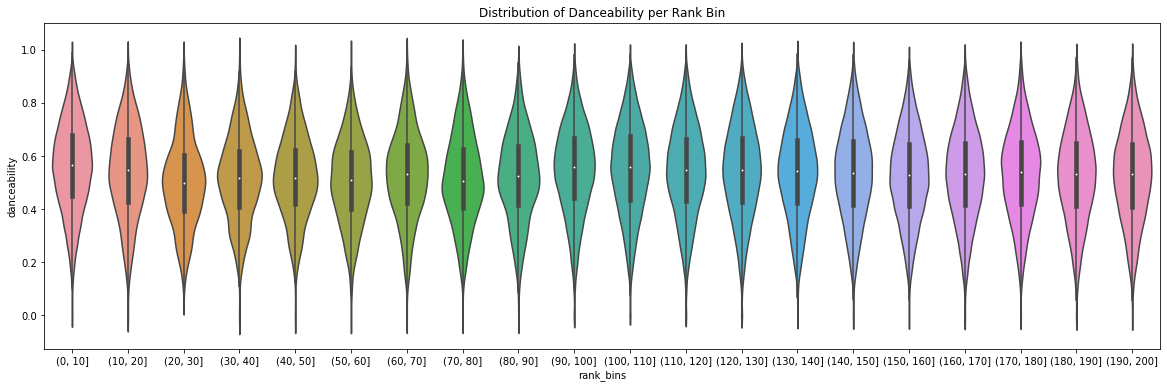

In [25]:
#plot distributions for danceability level
plt.figure(figsize=(20, 6))
plt.title("Distribution of Danceability per Rank Bin")
ax = sns.violinplot(x=acoustic_features["rank_bins"], y=acoustic_features['danceability'])

**Observations**

- Most distributions are symmetrical
- Even though danceability levels differ by rank, the levels tend to be similar for inviduals ranks
- Danceability levels for high ranks seems to be slightly higher than very low ranks



# 4. Audio Features vs. Rank Analysis

## 4.1 Audio Features vs. Rank

We will now do a formal analysis of the correlation between audio features and rank. To begin, let's make a correlation dataframe using the all the audio features and the rank column in ACOUSTIC_FEATURES.

In [47]:
#creates list of audio features
variables = list(acoustic_features.columns[4:17])
'''
add rank to list because we want to measure
it's correlation to the audio features
'''
variables.insert(0,'rank')

#create correlation dataframe
corr_df = acoustic_features[variables]
corr_df = corr_df.corr()
corr_df = corr_df.round(3)
corr_df

,rank,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
rank,1.000,0.028,-0.039,-0.000,-0.009,0.065,0.004,0.016,-0.039,0.014,-0.011,0.004,-0.014,0.012
acousticness,0.028,1.000,-0.182,-0.127,-0.701,0.096,-0.023,-0.000,-0.556,0.081,0.015,-0.172,-0.185,-0.212
danceability,-0.039,-0.182,1.000,-0.058,0.091,-0.176,0.023,-0.152,0.124,-0.071,0.173,-0.121,0.204,0.523
duration_ms,-0.000,-0.127,-0.058,1.000,0.068,0.043,0.005,0.062,0.049,-0.050,-0.084,0.018,0.061,-0.123
energy,-0.009,-0.701,0.091,0.068,1.000,-0.094,0.030,0.162,0.756,-0.068,0.099,0.210,0.190,0.302
instrumentalness,0.065,0.096,-0.176,0.043,-0.094,1.000,-0.007,-0.026,-0.244,-0.039,-0.103,-0.016,-0.042,-0.139
key,0.004,-0.023,0.023,0.005,0.030,-0.007,1.000,-0.000,0.016,-0.164,0.032,-0.003,0.006,0.028
liveness,0.016,-0.000,-0.152,0.062,0.162,-0.026,-0.000,1.000,0.034,0.009,0.230,-0.001,-0.017,-0.029
loudness,-0.039,-0.556,0.124,0.049,0.756,-0.244,0.016,0.034,1.000,-0.031,-0.006,0.166,0.167,0.159
mode,0.014,0.081,-0.071,-0.050,-0.068,-0.039,-0.164,0.009,-0.031,1.000,-0.085,0.016,-0.016,-0.002


We can use the correlation dataframe to create a heat map which will provide a visual representation of the correlation between each column in our dataframe. 

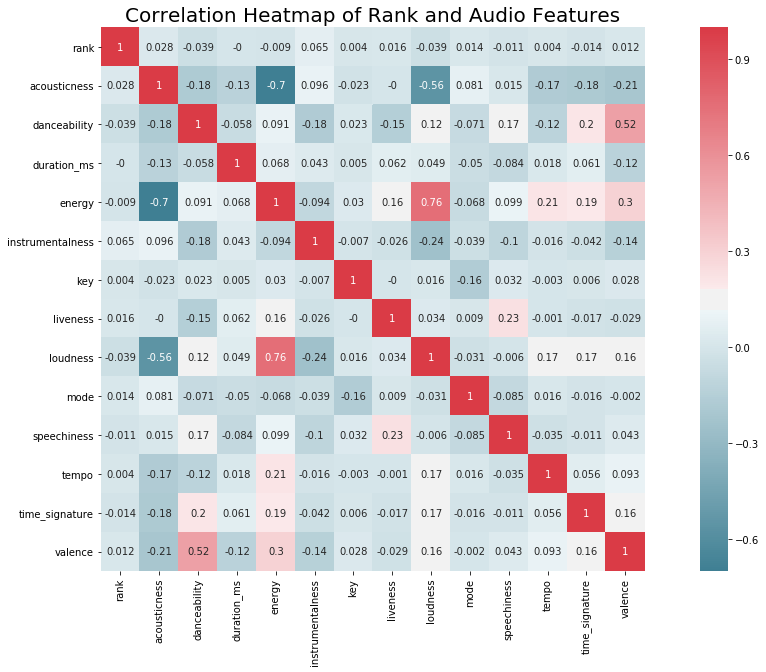

In [48]:
plt.figure(figsize=(20,10))
plt.title("Correlation Heatmap of Rank and Audio Features", fontsize=20)
sns.heatmap(corr_df, cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True, annot=True)
plt.show()

**Observations**

- Unfortunately, no audio feature is highly correlated to rank. The highest correlated audio feature to rank is instrumentalness (this represents the amount of vocals in a song). 
- Danceability and key are very low correlated to rank 
- Loudness and energy are highly correlated. This is not surprising as the two audio features are often associated.  

# 5. Linear Regression

## 5.1 Null Hypothesis

Our null hypothesis states that none of the acoustic features will influence rank. 

In the next step, we will verify the null hypothesis. 

## 5.2. Regression with OLS

In [43]:
features = acoustic_features.loc[:,'acousticness':'valence']
target = acoustic_features['rank']

In [44]:
sm_y = target
sm_X = features

sm_X = sm.add_constant(features)

OLS_model = sm.OLS(target,features).fit()
OLS_model.summary()

/Users/kavyadagli/Desktop/cmsc320-fall-19-final/env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   rank   R-squared (uncentered):                   0.843
Model:                            OLS   Adj. R-squared (uncentered):              0.843
Method:                 Least Squares   F-statistic:                          1.284e+05
Date:                Sun, 15 Dec 2019   Prob (F-statistic):                        0.00
Time:                        16:02:39   Log-Likelihood:                     -1.6440e+06
No. Observations:              311394   AIC:                                  3.288e+06
Df Residuals:                  311381   BIC:                                  3.288e+06
Df Model:                          13                                                  
Covariance Type:            nonrobust                                                  
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
acousticness        17.9925      0.370     48.593      0.000      17.267      18.718
danceability         8.0095      0.625     12.823      0.000       6.785       9.234
duration_ms       1.486e-05   8.77e-07     16.938      0.000    1.31e-05    1.66e-05
energy              40.9941      0.607     67.489      0.000      39.804      42.185
instrumentalness     8.9277      0.389     22.939      0.000       8.165       9.690
key                  0.3683      0.024     15.288      0.000       0.321       0.415
liveness             2.4200      0.434      5.582      0.000       1.570       3.270
loudness            -1.8377      0.027    -67.710      0.000      -1.891      -1.785
mode                 4.1986      0.189     22.247      0.000       3.829       4.568
speechiness         -7.6589      0.713    -10.747      0.000      -9.056      -6.262
tempo                0.0847      0.003     30.458      0.000       0.079       0.090
time_signature       9.9405      0.160     62.178      0.000       9.627      10.254
valence              0.2059      0.431      0.478      0.633      -0.639       1.051
==============================================================================
Omnibus:                    20664.823   Durbin-Watson:                   0.182
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            25285.203
Skew:                          -0.656   Prob(JB):                         0.00
Kurtosis:                       3.475   Cond. No.                     2.44e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.44e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# 6. Precting Song Rank Using Audio Features

# Sandbox

In [ ]:
year_slices = ['196', '197', '198', '199', '200', '201']

In [ ]:
for s in year_slices:
    plt.figure()
    
    sliced_df = df.loc[df.date.apply(lambda x: x[:3] == s)]
    
    scs.scatterplot(x='acousticness',
                y='danceability',
                hue='album',
                legend=False,
                data=sliced_df)

In [ ]:
for s in year_slices:
    plt.figure()
    
    sliced_df = df.loc[df.date.apply(lambda x: x[:3] == s)]
    
    scs.scatterplot(x='energy',
                y='danceability',
                hue='album',
                legend=False,
                data=sliced_df)

In [ ]:
for s in year_slices:
    plt.figure()
    
    sliced_df = df.loc[df.date.apply(lambda x: x[:3] == s)]
    
    scs.scatterplot(x='instrumentalness',
                y='speechiness',
                hue='album',
                legend=False,
                data=sliced_df)

In [ ]:
for s in year_slices:
    plt.figure()
    
    sliced_df = df.loc[df.date.apply(lambda x: x[:3] == s)]
    
    scs.scatterplot(x='energy',
                y='tempo',
                hue='album',
                legend=False,
                data=sliced_df)